# Jores et al 2021 Training 
**Authorship:**
Adam Klie, *05/18/2023*
***
**Description:**
Notebook to perform simple training of models on the Jores et al (2021) dataset. You can also use the `jores21_training.py` script as well if you want to run it that way.
***

In [67]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

In [19]:
# General imports
import os
import sys
import torch
import numpy as np
import pandas as pd
import xarray as xr
from copy import deepcopy 
import torchinfo
import pytorch_lightning

# EUGENe imports and settings
import eugene as eu
from eugene import models
from eugene import train
from eugene import settings
settings.dataset_dir = "/cellar/users/aklie/data/eugene/revision/jores21"
settings.output_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/output/fix/jores21"
settings.logging_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/logs/fix/jores21"
settings.config_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/configs/jores21"

# EUGENe packages
import seqdata as sd
import motifdata as md

# Print versions
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Eugene version: {eu.__version__}")
#print(f"SeqData version: {sd.__version__}")
#print(f"MotifData version: {md.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch Lightning version: {pytorch_lightning.__version__}")


Python version: 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:39:03) 
[GCC 11.3.0]
NumPy version: 1.23.5
Pandas version: 1.5.2
Eugene version: 0.0.8
PyTorch version: 2.0.0
PyTorch Lightning version: 2.0.0


# Load in the `leaf`, `proto` and `combined` `SeqData`s 

In [20]:
sdata_leaf = sd.open_zarr(os.path.join(settings.dataset_dir, "jores21_leaf_train.zarr"))
sdata_proto = sd.open_zarr(os.path.join(settings.dataset_dir, "jores21_proto_train.zarr"))

In [21]:
def concat_seqdatas(seqdatas, keys):
    for i, s in enumerate(seqdatas):
        s["batch"] = keys[i]
    return xr.concat(seqdatas, dim="_sequence")
sdata_combined = concat_seqdatas([sdata_leaf, sdata_proto], ["leaf", "proto"])

# Load in PFMs to initialize the 1st layer of the model with

In [10]:
# Grab motifs
core_promoter_elements = md.read_meme(os.path.join(settings.dataset_dir, "CPEs.meme"))
tf_clusters = md.read_meme(os.path.join(settings.dataset_dir, "TF-clusters.meme"))

# Smush them together, make function in the future
all_motifs = deepcopy(core_promoter_elements)
for motif in tf_clusters:
    all_motifs.add_motif(motif)
all_motifs

MotifSet with 78 motifs

# Train models

In [12]:
# Function for instantiating a new randomly initialized model
def prep_new_model(
    config,
    seed
):
    # Instantiate the model
    model = models.load_config(config_path=config, seed=seed)
    
    # Initialize the model prior to conv filter initialization
    models.init_weights(model, initializer="kaiming_normal")

    # Initialize the conv filters
    if model.arch_name == "Jores21CNN":
        layer_name = "arch.biconv.kernels"
        list_index = 0
    elif model.arch_name in ["CNN", "Hybrid", "DeepSTARR"]:
        layer_name = "arch.conv1d_tower.layers.0"
        list_index = None
    models.init_motif_weights(
        model=model,
        layer_name=layer_name,
        list_index=list_index,
        initializer="xavier_uniform",
        motifs=all_motifs,
        convert_to_pwm=False,
        divide_by_bg=True,
        motif_align="left",
        kernel_align="left"
    )

    # Return the model
    return model 

# Test the instantiation of each model to make sure this is working properly
model = prep_new_model("cnn.yaml", seed=0)
model = prep_new_model("hybrid.yaml", seed=0)
model = prep_new_model("jores21_cnn.yaml", seed=0)
model = prep_new_model("deepstarr.yaml", seed=0)

[rank: 0] Global seed set to 0


[rank: 0] Global seed set to 0
[rank: 0] Global seed set to 0
[rank: 0] Global seed set to 0


In [13]:
# Train 5 models with 5 different random initializations
training_sets = {"leaf": sdata_leaf}#, "proto": sdata_proto, "combined": sdata_combined}
configs = ["cnn.yaml", "hybrid.yaml", "jores21_cnn.yaml", "deepstarr.yaml"]
trials = 1
for training_set in training_sets:
    for trial in range(1, trials+1):
        for config in configs:

            # Print the model name
            sdata = training_sets[training_set]
            model_name = config.split(".")[0]
            print(f"{training_set} {model_name} trial {trial}")

            # Initialize the model
            model = prep_new_model(config, seed=trial)

            # Fit the model
            train.fit_sequence_module(
                model,
                sdata,
                seq_key="ohe_seq",
                target_keys=["enrichment"],
                in_memory=True,
                train_key="train_val",
                epochs=25,
                batch_size=128,
                num_workers=4,
                prefetch_factor=2,
                drop_last=False,
                name=model_name,
                version=f"{training_set}_trial_{trial}",
                seq_transforms={"ohe_seq": lambda x: torch.tensor(x, dtype=torch.float32).transpose(1, 2), "target": lambda x: torch.tensor(x, dtype=torch.float32)},
                seed=trial
            )

            # Make room for the next model 
            del model

[rank: 0] Global seed set to 1
[rank: 0] Global seed set to 1


leaf cnn trial 1
Dropping 0 sequences with NaN targets.
Loading ohe_seq and ['enrichment'] into memory


/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type    | Params
-----------------------------------------
0 | arch         | CNN     | 1.9 M 
1 | train_metric | R2Score | 0     
2 | val_metric   | R2Score | 0     
3 | test_metric  | R2Score | 0     
-----------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.535     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[rank: 0] Global seed set to 1
[rank: 0] Global seed set to 1


leaf hybrid trial 1
Dropping 0 sequences with NaN targets.
Loading ohe_seq and ['enrichment'] into memory


/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type    | Params
-----------------------------------------
0 | arch         | Hybrid  | 1.9 M 
1 | train_metric | R2Score | 0     
2 | val_metric   | R2Score | 0     
3 | test_metric  | R2Score | 0     
-----------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.703     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[rank: 0] Global seed set to 1
[rank: 0] Global seed set to 1


leaf jores21_cnn trial 1
Dropping 0 sequences with NaN targets.
Loading ohe_seq and ['enrichment'] into memory


/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type       | Params
--------------------------------------------
0 | arch         | Jores21CNN | 5.4 M 
1 | train_metric | R2Score    | 0     
2 | val_metric   | R2Score    | 0     
3 | test_metric  | R2Score    | 0     
--------------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.423    Total estimated model par

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[rank: 0] Global seed set to 1
[rank: 0] Global seed set to 1


leaf deepstarr trial 1
Dropping 0 sequences with NaN targets.
Loading ohe_seq and ['enrichment'] into memory


/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | arch         | DeepSTARR | 5.3 M 
1 | train_metric | R2Score   | 0     
2 | val_metric   | R2Score   | 0     
3 | test_metric  | R2Score   | 0     
-------------------------------------------
5.3 M     Trainable params
0         Non-trainable params
5.3 M     Total params
21.036    Total estimated model params siz

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

---

In [83]:
settings.logging_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/logs/fix_full/jores21"

In [84]:
sdata_test = sd.open_zarr(os.path.join(settings.dataset_dir, "jores21_leaf_test.zarr"))

In [85]:
import glob
from eugene import plot as pl

In [102]:
trial = 5
name = "jores21_cnn"

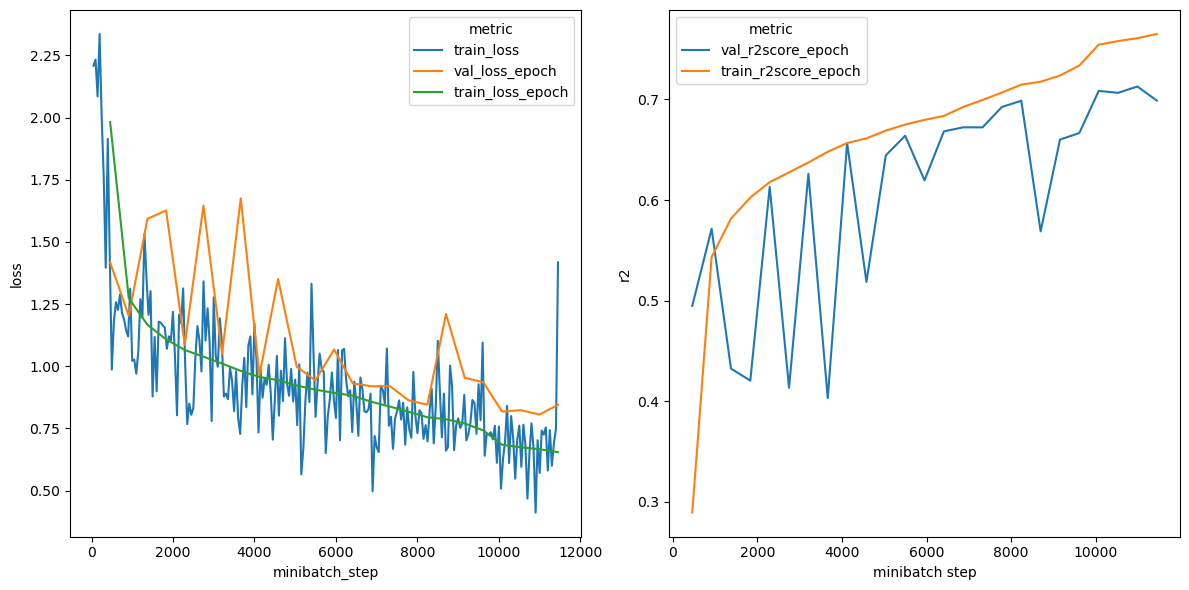

In [103]:
# Print the training summary
pl.training_summary(os.path.join(eu.settings.logging_dir, name, f"leaf_trial_{trial}"))

In [104]:
model = models.load_config(config_path=f"{name}.yaml")
model_file = glob.glob(os.path.join(eu.settings.logging_dir, name, f"leaf_trial_{trial}", "checkpoints", "*.ckpt"))[0]
best_model = models.SequenceModule.load_from_checkpoint(model_file, arch=model.arch)

[rank: 0] Global seed set to 5


In [105]:
model_file

'/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/logs/fix_full/jores21/jores21_cnn/leaf_trial_5/checkpoints/epoch=23-step=10992.ckpt'

In [106]:
# Grab the predictions on the test set
ohe_seqs = sdata_test["ohe_seq"].to_numpy().transpose(0, 2, 1)
preds = best_model.predict(ohe_seqs, batch_size=128).detach().numpy().squeeze()
sdata_test[f"enrichment_predictions"] = preds

Predicting on batches:   0%|          | 0/55 [00:00<?, ?it/s]

Dropping 0 sequences with NaN targets.


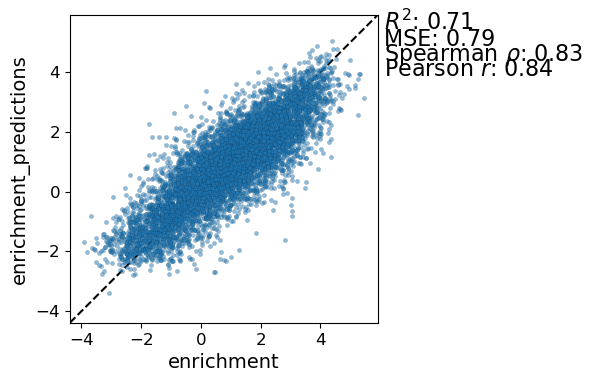

In [107]:
ax = pl.performance_scatter(
    sdata_test, 
    target_keys="enrichment", 
    prediction_keys="enrichment_predictions",
    alpha=0.5,
    figsize=(4, 4),
    rasterized=True,
)

In [108]:
# Get R2 and MSE
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import spearmanr, pearsonr

r2 = r2_score(sdata_test["enrichment"], sdata_test["enrichment_predictions"])
mse = mean_squared_error(sdata_test["enrichment"], sdata_test["enrichment_predictions"])
spearman = spearmanr(sdata_test["enrichment"], sdata_test["enrichment_predictions"])
pearson = pearsonr(sdata_test["enrichment"], sdata_test["enrichment_predictions"])

print(f"R2: {r2}")
print(f"MSE: {mse}")
print(f"Spearman: {spearman}")
print(f"Pearson: {pearson}")

R2: 0.7067654385438759
MSE: 0.7929888200474486
Spearman: SpearmanrResult(correlation=0.8343476085043603, pvalue=0.0)
Pearson: PearsonRResult(statistic=0.8413438779837487, pvalue=0.0)
